In [3]:
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import os
import matplotlib.pyplot as plt
from Algorithms.HelicopterTriggerIndex import *
import seaborn as sns
import warnings
import pandas as pd
sns.set()

In [4]:
folder = "source_disk/era5/specific_patterns/"
outsource = "../Thesis_source/MasterThesis/Figures/"


In [5]:
htiseason = []
for file in sorted(os.listdir(folder))[1:]:
    month = int(file[4:6])
    if month < 5 or month > 9:
        htiseason.append(file)


In [6]:
analysis = pd.read_csv("source/analysis_dataset_new.csv")
cases = pd.read_csv("source/dataset_new.csv")
height_cases = pd.read_csv("source/dataset_H.csv")

In [7]:
def f_2_m(f,R=0):
    # Meter til Fot
    if R:
        return 3.2808399*f

    # Fot til Meter
    else:
        return 0.3048*f
    
def estimate_pl(geopotential_pl,case_height):
    mean_height_pl = f_2_m(geopotential_pl.mean(axis=1).mean(axis=1)/9.81,1)
    dist = mean_height_pl - case_height
    return int(np.argmin(abs(dist)).values)

def get_height_value_from_pl(geopotential_pl,variable_pl,height=750,pmax=0,pmin=1):
    # pmax is index of levellist [975,950,925,900,875,850,825,800], if longer, geopotential is longer.
    # Also Assume 9.81 is correct gravitational constant ( should be to 1%)
    z2,z1 = geopotential_pl.isel(level=pmin)/9.81 , geopotential_pl.isel(level=pmax)/9.81
    v2,v1 = variable_pl.isel(level=pmin) , variable_pl.isel(level=pmax)
    variableperheight = (v2-v1)/(z2-z1)
    result = v1 + variableperheight*(height - z1)
    return result

def w_from_omega(omega,P,T,mix):
    eps = 0.622
    R_d = 287.058 
    T_v = T*((mix + eps)/(eps*(1+mix)))
    rho = P/ (R_d*T_v)
    return (-omega)/(rho*9.81)


In [8]:
routes = {}
for i, row in analysis.iterrows():
    try:
        routes[row[2]].append(row[3])
    except KeyError:
        routes[row[2]] = [row[3]]

for i, row in cases.iterrows():
    try:
        routes[row[2]].append(row[3])
    except KeyError:
        routes[row[2]] = [row[3]]


In [10]:
cases

,date,time,place1,place2,lat,lon,height,temp,type
0,20080205,7,ENBR,NaN,60.291,5.222,2499.992,NaN,FW
1,20080213,17,ENAT,NaN,69.980,23.360,13000.000,NaN,FW
2,20080222,8,ENFL,NaN,61.390,5.020,3800.000,NaN,FW
3,20080404,18,ENBR,NaN,60.291,5.220,3000.000,NaN,FW
4,20080415,15,ENCN,NaN,58.210,8.080,NaN,NaN,FW
...,...,...,...,...,...,...,...,...,...
275,20181030,21,ENZV,NaN,59.350,6.017,8000.000,NaN,FW
276,20181130,18,ENBR,NaN,60.291,5.222,6000.000,NaN,FW
277,20190101,14,ENBO,NaN,67.270,14.350,NaN,NaN,FW
278,20190114,8,ENML,NaN,62.745,7.263,91.000,NaN,FW


In [68]:
Th = []
Tf = []
for ds in [cases]:
    for i, row in ds.iterrows():

        height = row[-3]
        if not height > 0:
            height = f_2_m(750,1)
            continue
        lat,lon = row[4:6]
        if lat < 0:
            # nan
            continue
        xarray = xr.open_dataset(folder+"%i%2.2i.nc"%(row[0],row[1])).isel(time=0)
        
        ind = estimate_pl(xarray["z"],height)
        part = xarray["msl"]/100
        T750 = get_height_value_from_pl(xarray["z"],xarray["t"],height=f_2_m(height),pmax=ind,pmin=ind+1)-273.15
        T750 = T750.sel(latitude=lat ,method = "nearest").sel(longitude=lon,method="nearest")
        if row[-1] == "H":
            Th.append(T750)
        else:
            Tf.append(T750)
        

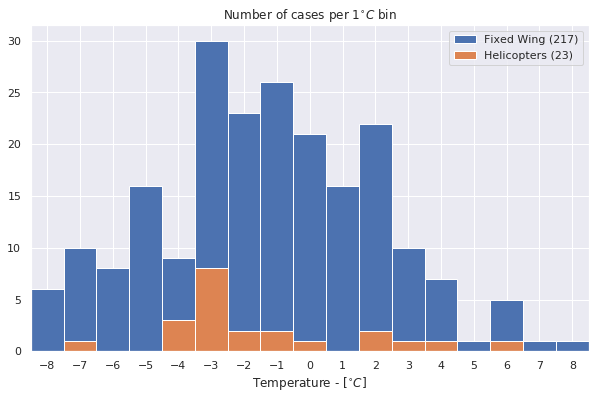

In [96]:
plt.figure(figsize=(10,6))
plt.hist(Th+Tf,bins=np.linspace(-8.5,8.5,18),label="Fixed Wing (%i)"%(len(Tf)))
plt.hist(Th,bins=np.linspace(-8.5,8.5,18),label="Helicopters (%i)"%(len(Th)))
plt.title("Number of cases per $1^{\circ}C$ bin")
plt.legend()
plt.xticks(range(-8,9,1))
plt.xlabel("Temperature - [$^{\circ}C$]")
plt.xlim(-8.5,8.5)
plt.savefig(outsource+"temperature.pdf")
plt.show()

## Temperature and mslp


In [152]:
def standard_deviation(M_mean,T_mean,filterlist):
    Sm = 0
    St =0
    n  = 0
    for ds in [cases,analysis]:
        for i, row in ds.iterrows():
            if row[2] not in filterlist:
                continue
            height = row[-3]
            if not height > 0:
                height = f_2_m(750,1)
                continue
            xarray = xr.open_dataset(folder+"%i%2.2i.nc"%(row[0],row[1])).isel(time=0)
            
            ind = estimate_pl(xarray["z"],height)
            T750 = get_height_value_from_pl(xarray["z"],xarray["t"],height=f_2_m(height),pmax=ind,pmin=ind+1)-273.15

            Sm += abs(xarray["msl"]/100 - M_mean)**2
            St += abs(T750 - T_mean)**2
            n  += 1
    return np.sqrt(Sm/n), np.sqrt(St/n)  
                          
            
def filtered_composite(filterlist,filtername):
    mslp = 0
    temp = 0
    n=0
    for ds in [cases,analysis]:
        for i, row in ds.iterrows():
            if row[2] not in filterlist:
                continue

            height = row[-3]
            if not height > 0:
                height = f_2_m(750,1)
                continue
            xarray = xr.open_dataset(folder+"%i%2.2i.nc"%(row[0],row[1])).isel(time=0)

            ind = estimate_pl(xarray["z"],height)
            part = xarray["msl"]/100
            T750 = get_height_value_from_pl(xarray["z"],xarray["t"],height=f_2_m(height),pmax=ind,pmin=ind+1)-273.15
            temp += T750
            mslp += part
            n +=1

    temp = temp/(n)    
    mslp = mslp/(n)
    
    mstd,tstd = standard_deviation(mslp,temp,filterlist)
    
    plt.figure(figsize = (10,4))
    ax = plt.subplot(projection=ccrs.PlateCarree())
    temp.plot.contourf(ax=ax,transform=ccrs.PlateCarree(),levels=range(-10,10+1),cmap="RdBu_r")
    cs = mslp.plot.contour(ax=ax,transform=ccrs.PlateCarree(),levels=range(960,1050,4))
    ax.coastlines("50m")
    ax.clabel(cs, inline=1, fontsize=10)
    ax.set_title("Composite of MSLP and Temperature for (%i) cases in "%n + filtername)
    
    plt.figure(figsize = (10,4))
    ax = plt.subplot(projection=ccrs.PlateCarree())
    tstd.plot.contourf(ax=ax,transform=ccrs.PlateCarree(),levels=range(10),cmap="RdBu_r")
    cs = mstd.plot.contour(ax=ax,transform=ccrs.PlateCarree(),levels=range(0,20,2))
    ax.coastlines("50m")
    ax.clabel(cs, inline=1, fontsize=10)
    ax.set_title("Variance of MSLP and Temperature for (%i) cases in "%n + filtername)


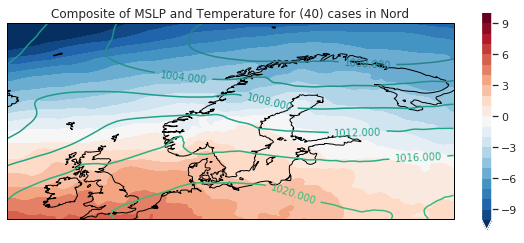

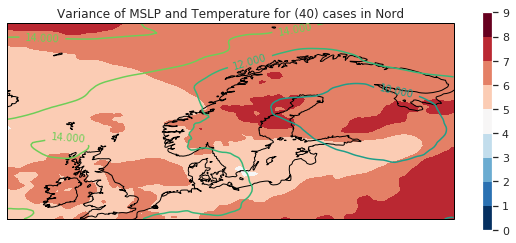

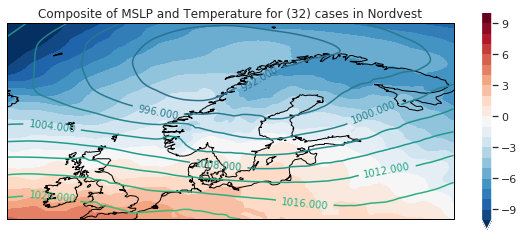

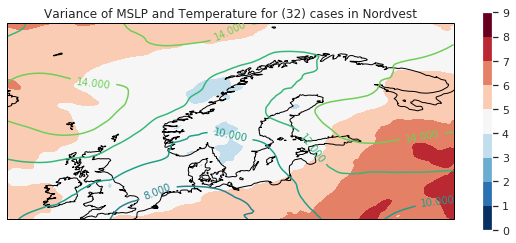

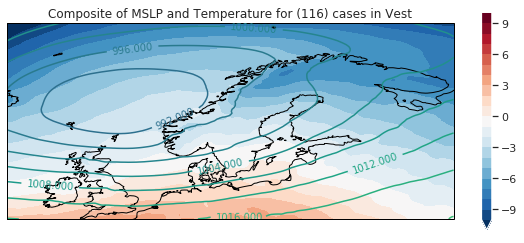

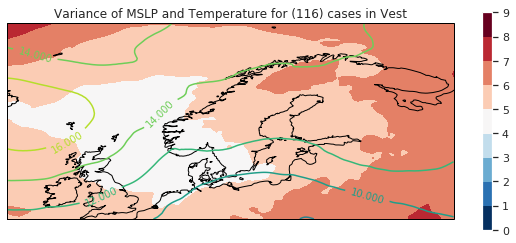

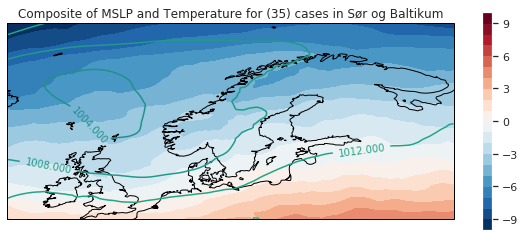

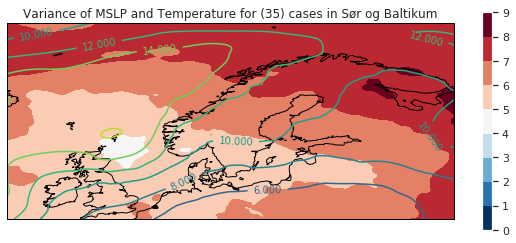

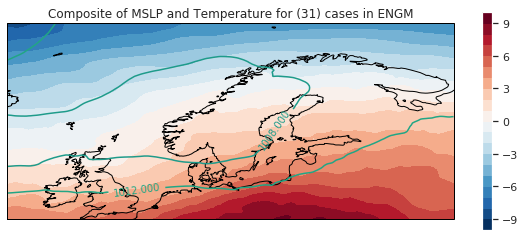

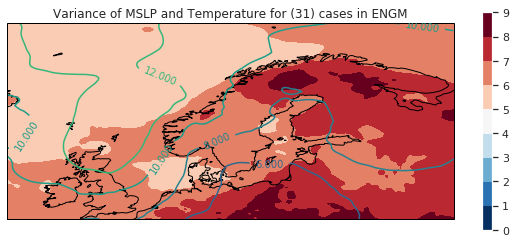

In [153]:
nord = ["ENRA","ENTC","ENBO","ENBN","ENUS","OffshoreN","ENAT","ENHK","ENHF","ENST","ENDU","ENNA","ENEV","ENAN","ENSK","ENHV"]
innland = ["ENGM"]
nordvest = ["ENAL","ENML","ENSE","ENKB","ENUC","OffshoreNV","ENVA","ENHE","ENOV","ENOL"]
vestkyst = ["ENFL","ENBR","ENZV","ENXA","ENXV","ENQS","ENQE","ENSF","Offshore","YME","ENBL","ENHD","ENSG"]
sørkyst = ["EKAH","ENCN","EKCH","EKBI","ESSA","EKEB","ENTO","ESMS","ESTA","EFHK","ESGG"]

filtered_composite(nord,"Nord")
filtered_composite(nordvest,"Nordvest")
filtered_composite(vestkyst,"Vest")
filtered_composite(sørkyst,"Sør og Baltikum")
filtered_composite(innland, "ENGM")

Text(0.5, 1.0, 'Composite of MSLP and Temperature for HTI-season cases')

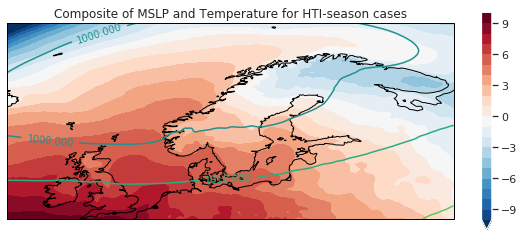

In [17]:
mslp = 0
temp = 0
n=0
for i, row in analysis.iterrows():
    height = row[4]
    if not height > 0:
        height = f_2_m(750,1)
    n+=1
    xarray = xr.open_dataset(folder+"%i.nc"%row[0]).isel(time=row[1])
    part = xarray["msl"]/100
    T750 = get_height_value_from_pl(xarray["z"],xarray["t"],height=f_2_m(height))-273.15
    temp += T750
    mslp+=part

for i, row in cases.iterrows():
    
    month = int(str(row[0])[4:6])
    if month >= 5 and month <= 9:
        continue
    n +=1
    height = row[4]
    if not height > 0:
        height = f_2_m(750,1)
    xarray = xr.open_dataset(folder+"%i.nc"%row[0]).isel(time=row[1])

    part = xarray["msl"]/100
    T750 = get_height_value_from_pl(xarray["z"],xarray["t"],height=f_2_m(height))-273.15
    temp += T750
    mslp += part
    
temp = temp/(n)
mslp = mslp/(n)
plt.figure(figsize = (10,4))
ax = plt.subplot(projection=ccrs.PlateCarree())
temp.plot.contourf(ax=ax,transform=ccrs.PlateCarree(),levels=range(-10,10+1),cmap="RdBu_r")
cs = mslp.plot.contour(ax=ax,transform=ccrs.PlateCarree(),levels=range(960,1050,10))
ax.coastlines("50m")
ax.clabel(cs, inline=1, fontsize=10)
ax.set_title("Composite of MSLP and Temperature for HTI-season cases")


In [1]:
plt.figure(figsize = (10,4))
ax = plt.subplot(projection=ccrs.PlateCarree())
temp.plot.contourf(ax=ax,transform=ccrs.PlateCarree(),levels=range(-10,10+1),cmap="RdBu_r")
cs = mslp.plot.contour(ax=ax,transform=ccrs.PlateCarree(),levels=range(960,1050,10))
ax.coastlines("50m")
ax.clabel(cs, inline=1, fontsize=10)
ax.set_title("Composite of MSLP and Temperature for HTI-season cases")


NameError: name 'plt' is not defined

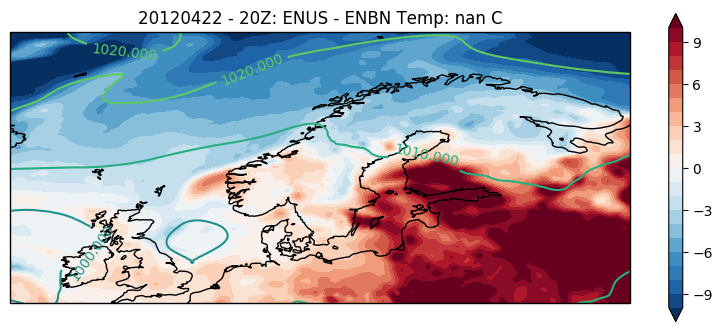

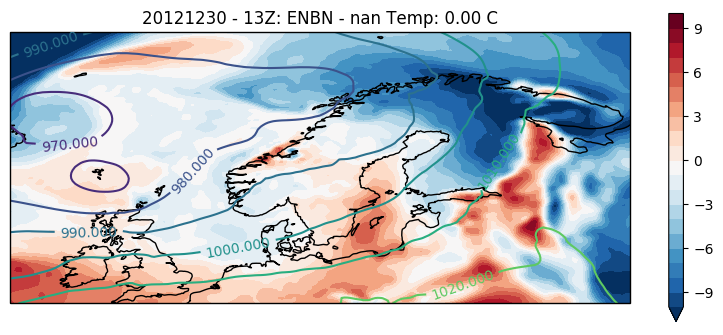

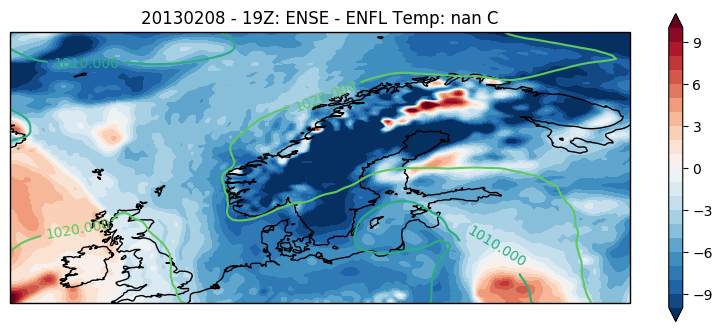

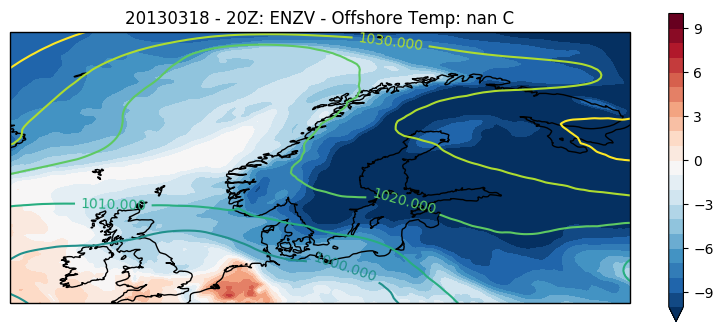

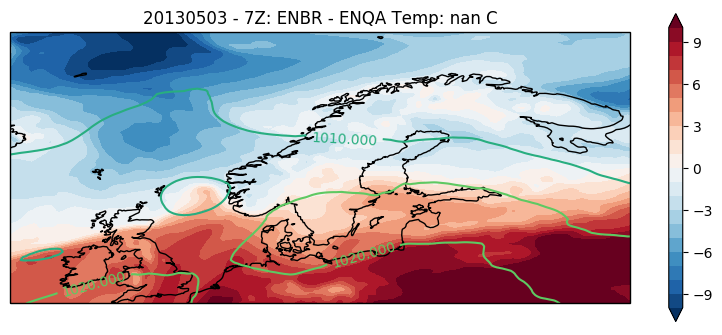

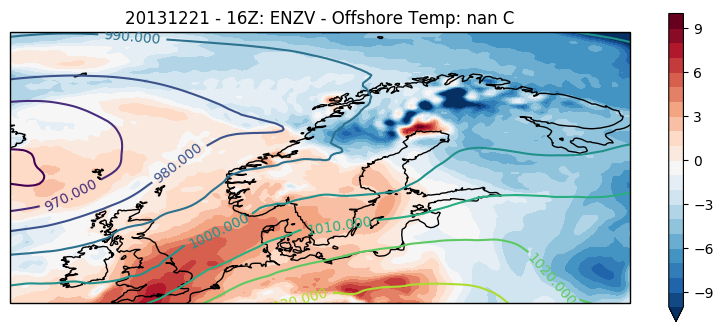

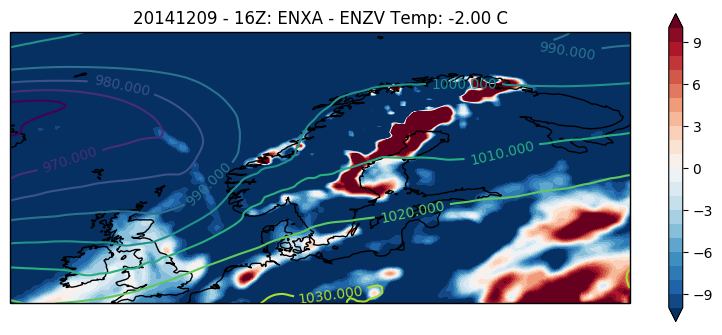

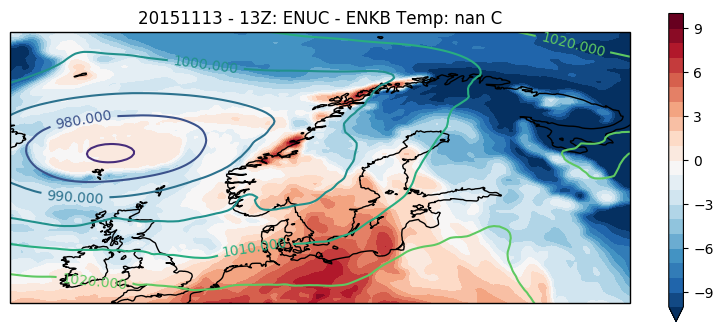

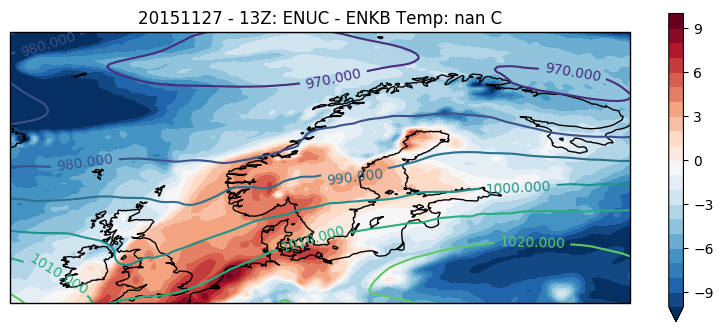

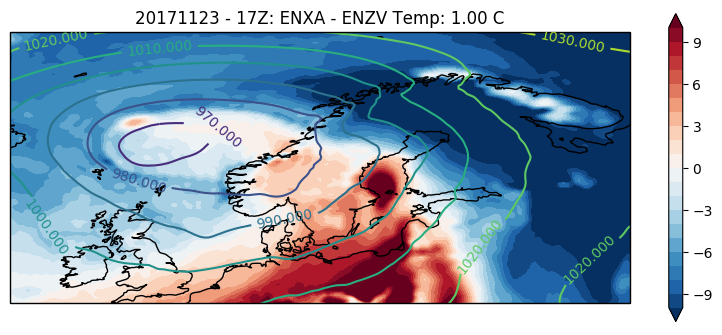

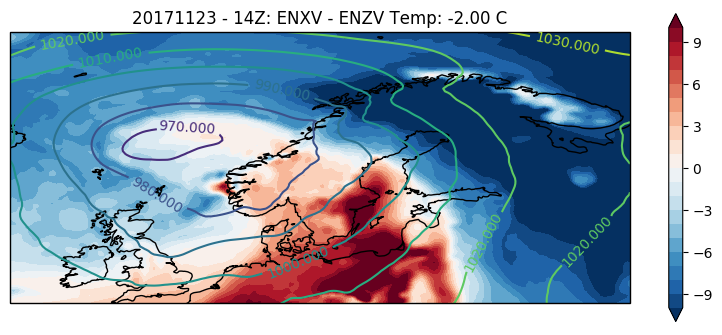

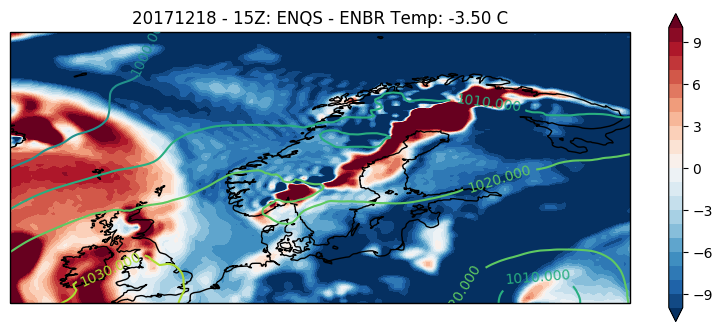

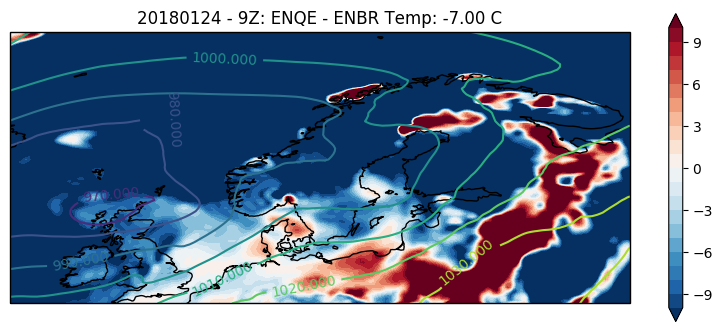

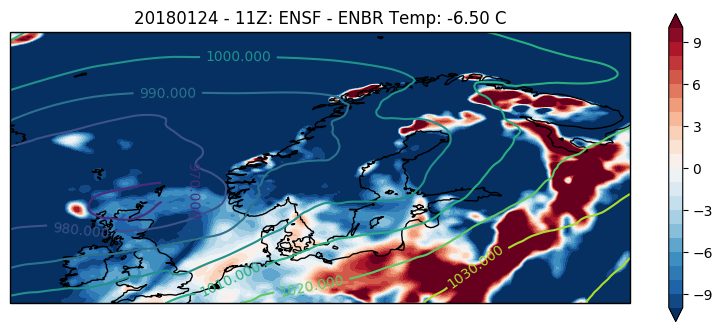

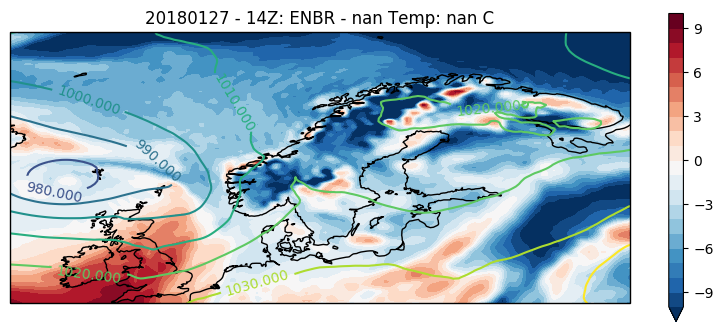

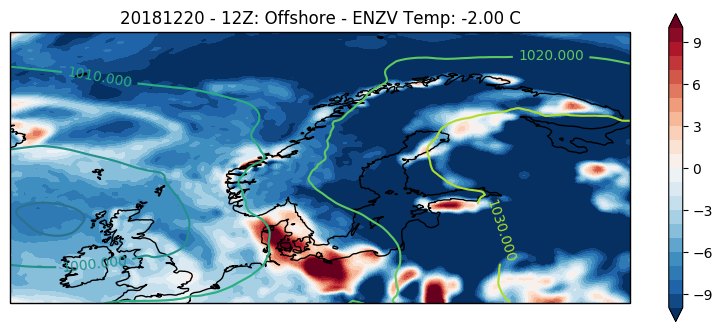

In [172]:
for i, row in analysis.iterrows():
    height = row[4]
    if not height > 0:
        height = f_2_m(750,1)
        
    xarray = xr.open_dataset(folder+"%i.nc"%row[0]).isel(time=row[1])
    part = xarray["msl"]/100
    T750 = get_height_value_from_pl(xarray["z"],xarray["t"],height=f_2_m(height))-273.15
    temp = row[-2]
    plt.figure(figsize = (10,4))


    ax = plt.subplot(projection=ccrs.PlateCarree())
    T750.plot.contourf(ax=ax,transform=ccrs.PlateCarree(),levels=range(-10,10+1),cmap="RdBu_r")
    cs = part.plot.contour(ax=ax,transform=ccrs.PlateCarree(),levels=range(960,1050,10))
    ax.coastlines("50m")
    ax.clabel(cs, inline=1, fontsize=10)
    ax.set_title(str(row[0]) +" - "+ str(row[1])+ "Z: " + row[2] +" - "+ str(row[3]) + " Temp: %.2f C"%row[-2])
    

In [19]:
Z975 = 0
Z950 = 0
Z925 = 0
Z900 = 0
Z875 = 0
Z850 = 0
Z825 = 0
Z800 = 0
n = 0
for day in htiseason:
    n +=1
    xarray = xr.open_dataset(folder+day)
    Z975 += xarray["z"].sel(level=975).mean("time")/9.81
    Z950 += xarray["z"].sel(level=950).mean("time")/9.81
    Z925 += xarray["z"].sel(level=925).mean("time")/9.81
    Z900 += xarray["z"].sel(level=900).mean("time")/9.81
    Z875 += xarray["z"].sel(level=875).mean("time")/9.81
    Z850 += xarray["z"].sel(level=850).mean("time")/9.81
    Z825 += xarray["z"].sel(level=825).mean("time")/9.81
    Z800 += xarray["z"].sel(level=800).mean("time")/9.81
Z975 = Z975/len(htiseason)
Z950 = Z950/len(htiseason) 
Z925 = Z925/len(htiseason) 
Z900 = Z900/len(htiseason)  
Z875 = Z875/len(htiseason)
Z850 = Z850/len(htiseason) 
Z825 = Z825/len(htiseason) 
Z800 = Z800/len(htiseason)   

KeyError: 875

In [20]:
Z975 = Z975/n
Z950 = Z950/n 
Z925 = Z925/n 
Z900 = Z900/n  
Z875 = Z875/n
Z850 = Z850/n 
Z825 = Z825/n 
Z800 = Z800/n   


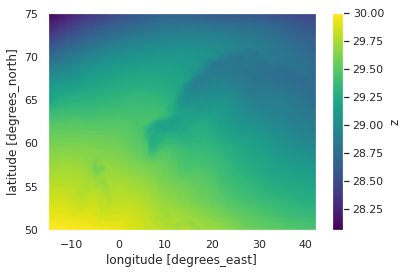

In [27]:
((f_2_m(Z800,1) - f_2_m(Z975,1))/(175)).plot()

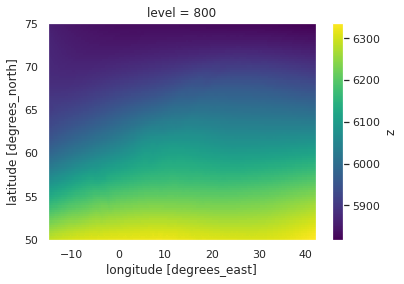

In [22]:
f_2_m(Z800,1).plot()

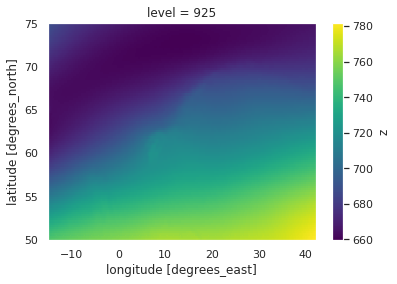

In [23]:
Z925.plot()

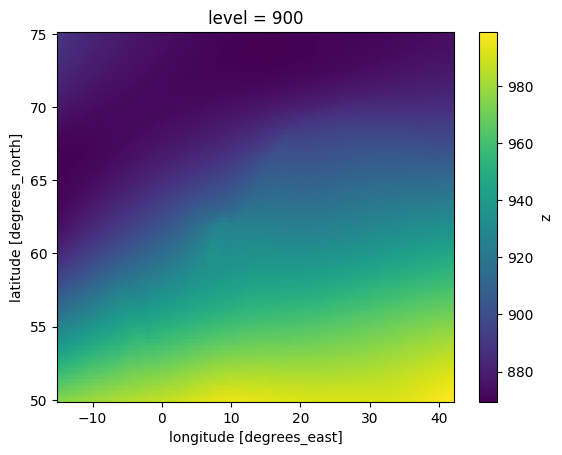

In [267]:
Z900.plot()

In [95]:
warnings.filterwarnings("ignore", category=RuntimeWarning)

def get_height_value_from_pl(geopotential_pl,variable_pl,height=750,pmax=975,pmin=950):
    # Also Assume 9.81 is correct gravitational constant ( should be to 1%)
    z2,z1 = geopotential_pl.sel(level=pmin)/9.81 , geopotential_pl.sel(level=pmax)/9.81
    v2,v1 = variable_pl.sel(level=pmin) , variable_pl.sel(level=pmax)
    variableperheight = (v2-v1)/(z2-z1)
    result = v1 + variableperheight*(height - z1)
    return result

def w_from_omega(omega,P,T,mix):
    eps = 0.622
    R_d = 287.058 
    T_v = T*((mix + eps)/(eps*(1+mix)))
    rho = P/ (R_d*T_v)
    return (-omega)/(rho*9.81)

mslpmax = -30000000
mslpmin = 30000000
mslpmean = 0

T750max = 0
T750min = 3000
T750mean= 0

W750max = -3000
W750min = 3000
W750mean= 0

SSTmax  = 0
SSTmin  = 300
SSTmean = 0

for day in htiseason:
    xarray = xr.open_dataset(folder+day)
    
    T750 = get_height_value_from_pl(xarray["z"],xarray["t"])
    W750 = get_height_value_from_pl(xarray["z"],xarray["w"])
    
    Tmin = T750.min("time")
    Smin = xarray["sst"].min("time")
    Wmin = W750.min("time")
    Pmin = xarray["msl"].min("time")/100
    
    Tmax = T750.max("time")
    Smax = xarray["sst"].max("time")
    Wmax = W750.min("time")
    Pmax = xarray["msl"].max("time")/100
    
    T750min = np.where(Tmin < T750min, Tmin,T750min)
    SSTmin = np.where(Smin < SSTmin, Smin,SSTmin)
    W750min = np.where(Tmin < W750min, Wmin, W750min)
    mslpmin = np.where(Pmin < mslpmin, Pmin, mslpmin)
    
    T750max = np.where(T750max < Tmax, Tmax,T750max)
    SSTmax = np.where(SSTmax < Smax, Smax,SSTmax)
    W750max = np.where(W750max < Wmax, Wmax,W750max)
    mslpmax = np.where(mslpmax < Pmax, Pmax, mslpmax)
    
    T750mean += T750.mean("time")
    W750mean += W750.mean("time")
    SSTmean += xarray["sst"].mean("time")
    mslpmean += xarray["msl"].mean("time")/100

T750min = ((T750mean*0) + T750min - 273.15)
W750min = (W750mean*0 + W750min)
SSTmin = ((Smin*0) + SSTmin - 273.15)
mslpmin = (Pmin*0 + mslpmin)

T750max = ((T750mean*0) + T750max - 273.15)
SSTmax = ((Smax*0) + SSTmax - 273.15)
W750max = (W750mean*0 + W750max)
mslpmax = (Pmax*0 + mslpmax)

T750mean = ((T750mean)/len(htiseason)) - 273.15
SSTmean = (SSTmean/len(htiseason))  - 273.15  
W750mean = W750mean/len(htiseason)
mslpmean = mslpmean/len(htiseason)


In [68]:
R_d = 287
eps = 0.622
mix = 0.05
T_v = T750min *((mix + eps)/(eps*(1+mix)))
rho = ((975+950)/2)/(R_d *T_v )
w = W750min / (rho*9.81)

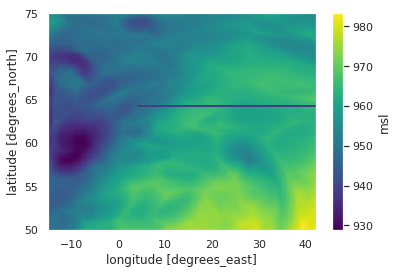

In [99]:
mslpmin.plot()


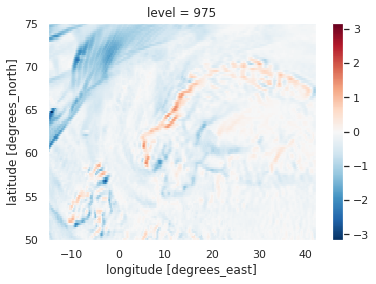

In [101]:
W750min.plot()

Text(0.5, 0, 'Longitude')

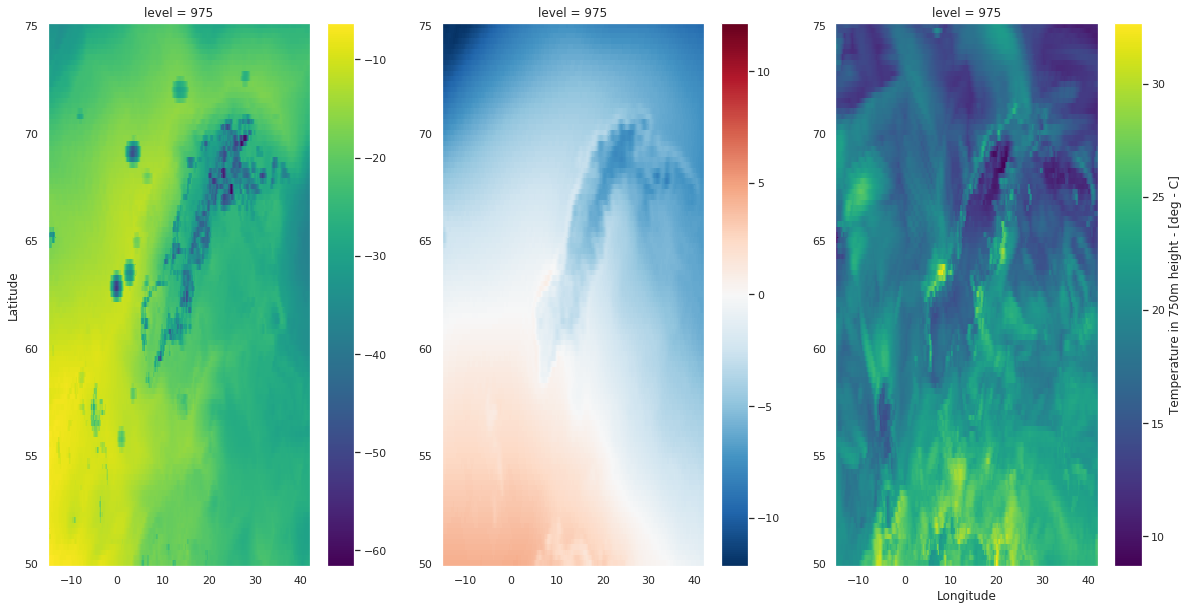

In [37]:

figure,axs = plt.subplots(1,3,figsize = (20,10))
(T750min).plot(ax=axs[0],cbar_kwargs = {"label" : ""})
(T750mean).plot(ax=axs[1],cbar_kwargs = {"label" : ""})
(T750max).plot(ax=axs[2],cbar_kwargs = {"label" : "Temperature in 750m height - [deg - C]"})

axs[0].set_ylabel("Latitude")
axs[0].set_xlabel("")
axs[1].set_ylabel("")
axs[1].set_xlabel("")
axs[2].set_ylabel("")
axs[2].set_xlabel("Longitude")

Text(0.5, 0, 'Longitude')

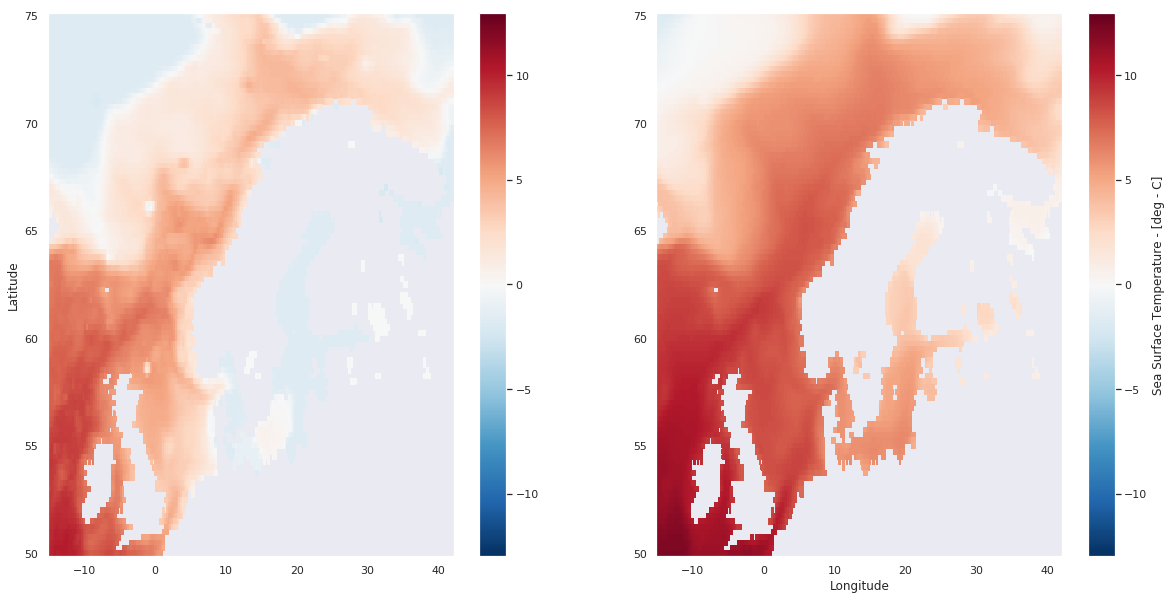

In [76]:
figure,axs = plt.subplots(1,2,figsize = (20,10))
(SSTmin).plot(ax=axs[0],vmin=-13,cbar_kwargs = {"label" : ""})
(SSTmean-273.15).plot(ax=axs[1],vmin=-13,cbar_kwargs = {"label" : "Sea Surface Temperature - [deg - C]"})

axs[0].set_ylabel("Latitude")
axs[0].set_xlabel("")
axs[1].set_ylabel("")
axs[1].set_xlabel("Longitude")

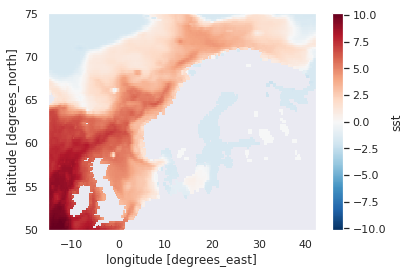